# Getting started with Mapper

In this notebook we explore a few of the core features included in `giotto-tda`'s implementation of the [Mapper algorithm](https://research.math.osu.edu/tgda/mapperPBG.pdf). 

## Useful references

* [An introduction to Topological Data Analysis: fundamental and practical aspects for data scientists](https://arxiv.org/abs/1710.04019)
* [An Introduction to Topological Data Analysis for Physicists: From LGM to FRBs](https://arxiv.org/abs/1904.11044)

**License: AGPLv3**

## Import libraries

In [1]:
# Data wrangling
import numpy as np
import pandas as pd  # Not a requirement of giotto-tda, but is compatible with the gtda.mapper module

# Data viz
from gtda.plotting import plot_point_cloud

# TDA magic
from gtda.mapper import (
    CubicalCover, # cover of the target
    make_mapper_pipeline,
    Projection, # our filter function
    plot_static_mapper_graph,
    plot_interactive_mapper_graph
)

# ML tools
from sklearn import datasets
from sklearn.cluster import DBSCAN # cluster algo
from sklearn.decomposition import PCA 

## Generate and visualise data
As a simple example, let's generate a two-dimensional point cloud of two concentric circles. The goal will be to examine how Mapper can be used to generate a topological graph that captures the salient features of the data.

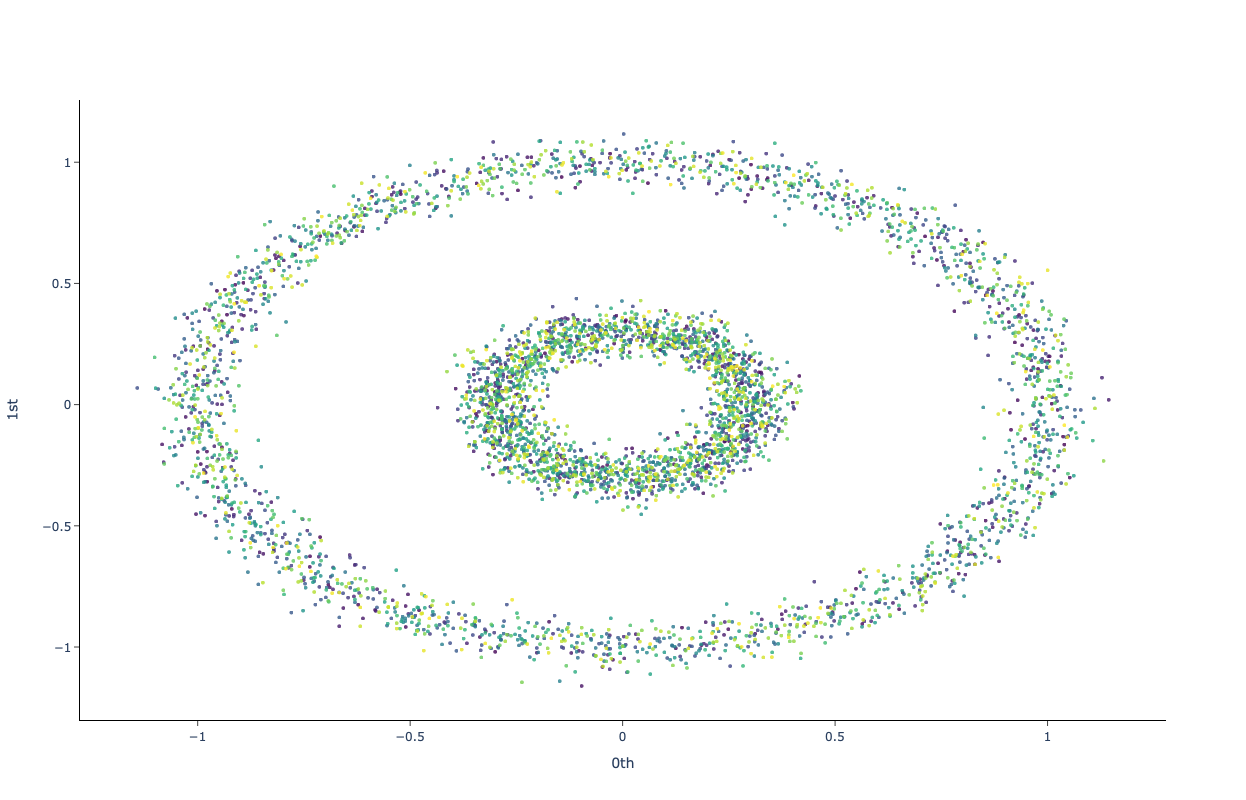

In [3]:
data, _ = datasets.make_circles(n_samples=5000, noise=0.05, factor=0.3, random_state=42)

plot_point_cloud(data)

## Configure the Mapper pipeline
Given a dataset ${\cal D}$ of points $x \in \mathbb{R}^n$, the basic steps behind Mapper are as follows:

1. Map ${\cal D}$ to a lower-dimensional space using a **filter function** $f: \mathbb{R}^n \to \mathbb{R}^m$. Common choices for the filter function include projection onto one or more axes via PCA or density-based methods. In `giotto-tda`, you can import a variety of filter functions as follows:

```python
from gtda.mapper.filter import FilterFunctionName
```

2. Construct a cover of the filter values ${\cal U} = (U_i)_{i\in I}$, typically in the form of a set of overlapping intervals which have constant length. As with the filter, a choice of cover can be imported as follows:

```python
from gtda.mapper.cover import CoverName
```

3. For each interval $U_i \in {\cal U}$ cluster the points in the preimage $f^{-1}(U_i)$ into sets $C_{i,1}, \ldots , C_{i,k_i}$. The choice of clustering algorithm can be any of `scikit-learn`'s [clustering methods](https://scikit-learn.org/stable/modules/clustering.html) or an implementation of agglomerative clustering in `giotto-tda`:

```python
# scikit-learn method
from sklearn.cluster import ClusteringAlgorithm
# giotto-tda method
from gtda.mapper.cluster import FirstSimpleGap
```

4. Construct the topological graph whose vertices are the cluster sets $(C_{i,j})_{i\in I, j \in \{1,\ldots,k_i\}}$ and an edge exists between two nodes if they share points in common: $C_{i,j} \cap C_{k,l} \neq \emptyset$. This step is handled automatically by `giotto-tda`.

These four steps are implemented in the `MapperPipeline`  object that mimics the `Pipeline` class from `scikit-learn`. We provide a convenience function `make_mapper_pipeline()` that allows you to pass the choice of filter function, cover, and clustering algorithm as arguments. For example, to project our data onto the $x$- and $y$-axes, we could setup the pipeline as follows:

In [49]:
# Define filter function - can be any scikit-learn transformer
filter_func = Projection(columns=[0, 1])

# Define cover
cover = CubicalCover(n_intervals=10, overlap_frac=0.1)

# Choose clustering algorithm - default is DBSCAN
clusterer = DBSCAN(eps=0.2, metric='euclidean')

# Configure parallelism of clustering step
n_jobs = 1

# Initialise pipeline
pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

## Visualise the Mapper graph

With the Mapper pipeline at hand, it is now a simple matter to visualise it. To warm up, let's examine the graph in two-dimensions using the default arguments of `giotto-tda`'s plotting function:

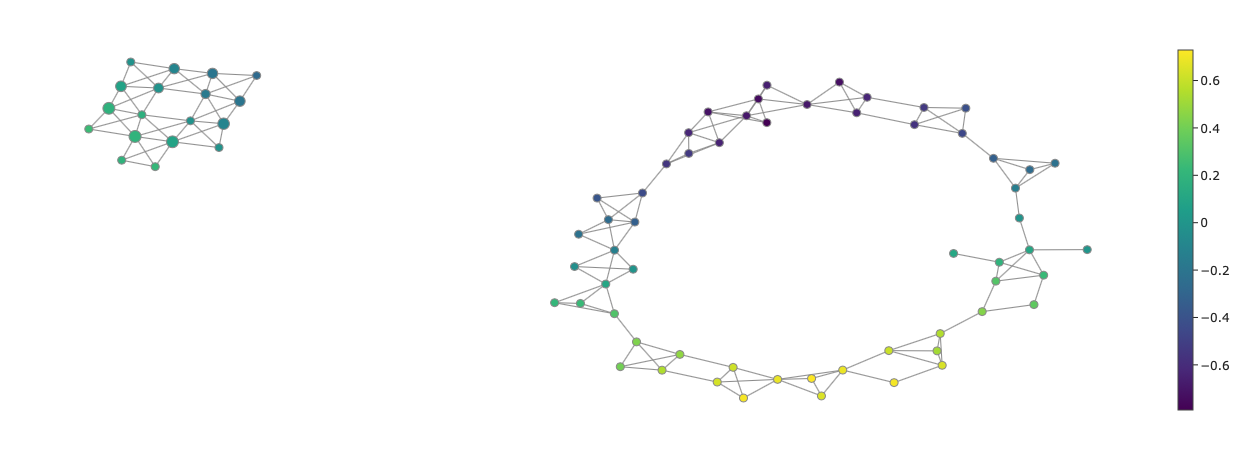

In [50]:
fig = plot_static_mapper_graph(pipe, data)
fig.show(config={'scrollZoom': True})

From the figure we can see that we have captured the salient topological features of our underlying data, namely two holes!

### Configure the coloring of the Mapper graph
By default, the nodes of the Mapper graph are colored by the mean value of the points that belong to a given node. However, in this example it is more instructive to colour by the $x$- and $y$-axes. This can be achieved by toggling the `color_by_columns_dropdown`, which calculates the coloring for each column in the input data array. At the same time, let's configure the choice of colorscale:

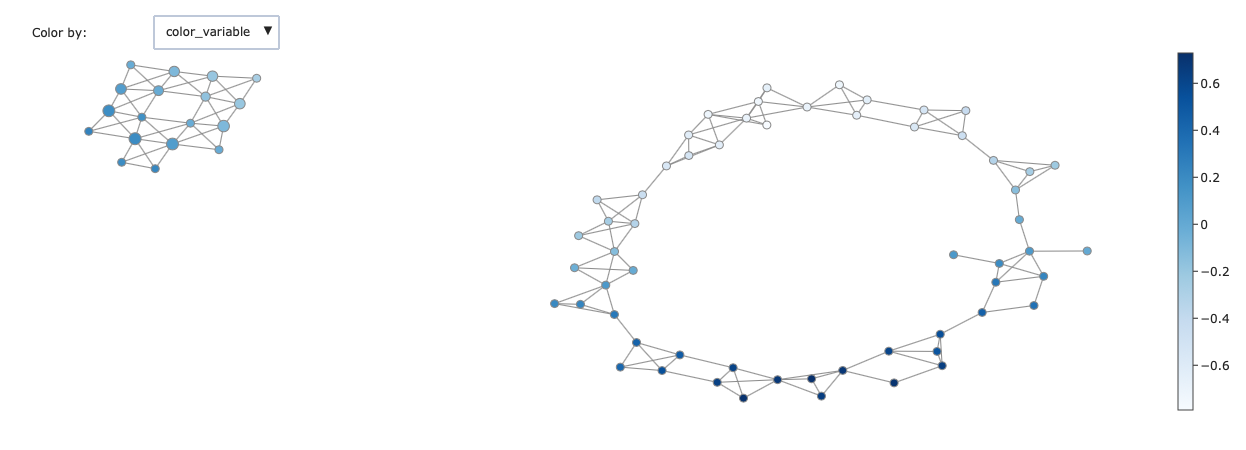

In [51]:
plotly_params = {"node_trace": {"marker_colorscale": "Blues"}}
fig = plot_static_mapper_graph(
    pipe, data, color_by_columns_dropdown=True, plotly_params=plotly_params
)
fig.show(config={'scrollZoom': True})

In the dropdown menu, the entry `color_variable` refers to a user-defined quantity to color by - by default it is the average value of the points in each node. In general, one can configure this quantity to be an array, a `scikit-learn` transformer, or a list of indices to select from the data. For example, coloring by a PCA component can be implemented as follows:

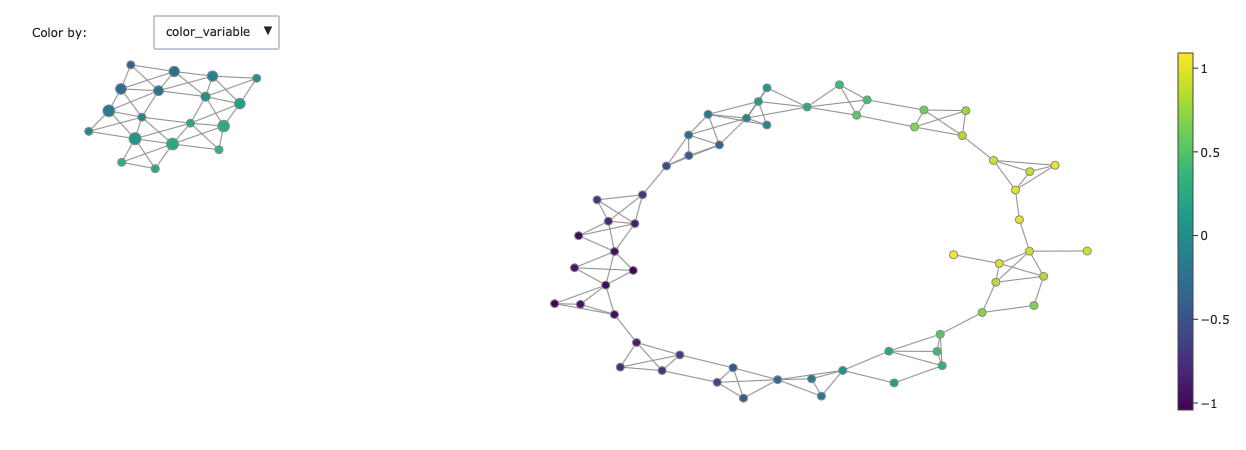

In [52]:
# Initialise estimator to color graph by
pca = PCA(n_components=1).fit(data)

fig = plot_static_mapper_graph(
    pipe, data, color_by_columns_dropdown=True, color_variable=pca
)
fig.show(config={'scrollZoom': True})

### Pass a pandas DataFrame as input

It is also possible to feed `plot_static_mapper_graph()` a pandas DataFrame:

In [53]:
data_df = pd.DataFrame(data, columns=["x", "y"])
data_df.head()

,x,y
0,-0.711917,-0.546609
1,0.306951,-0.007028
2,0.288193,0.123284
3,-0.892223,0.502352
4,-0.143615,0.938935


Before plotting we need to update the Mapper pipeline to know about the projection onto the column names. This can be achieved using the `set_params()` method as follows:

In [54]:
help(Projection)

Help on class Projection in module gtda.mapper.filter:

class Projection(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin)
 |  Projection(columns=0)
 |  
 |  Projection onto specified columns.
 |  
 |  In practice, this simply means returning a selection of columns of the
 |  data.
 |  
 |  Parameters
 |  ----------
 |  columns : int or list of int, optional, default: ``0``
 |      The column indices of the array to project onto.
 |  
 |  Method resolution order:
 |      Projection
 |      sklearn.base.BaseEstimator
 |      sklearn.base.TransformerMixin
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, columns=0)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  fit(self, X, y=None)
 |      Do nothing and return the estimator unchanged.
 |      
 |      This method exists to implement the usual scikit-learn API and hence
 |      work in pipelines.
 |      
 |      Parameters
 |      ----------
 |      X : array-like of

In [55]:
pipe.set_params(filter_func=Projection(columns=["x", "y"]));

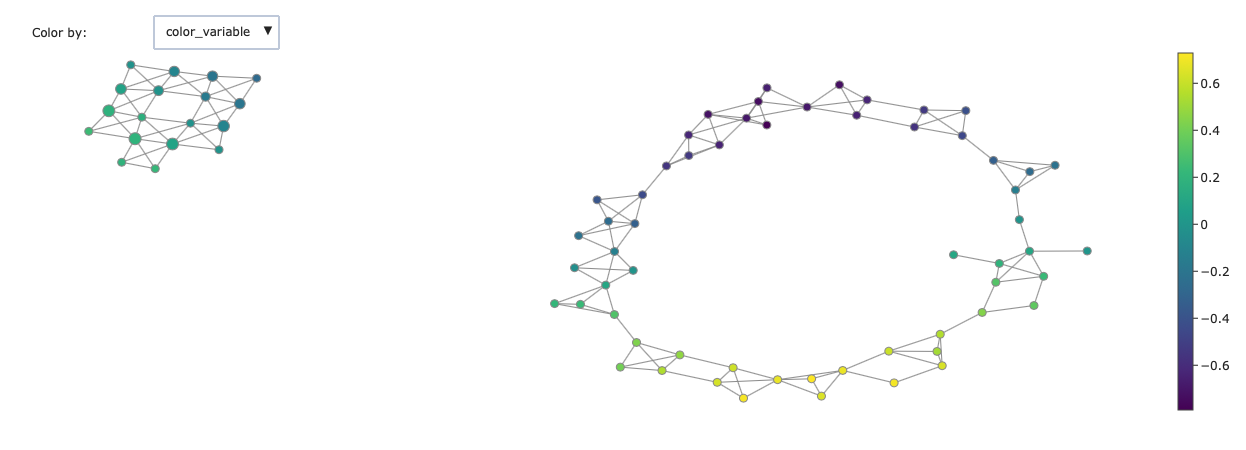

In [56]:
fig = plot_static_mapper_graph(pipe, data_df, color_by_columns_dropdown=True)
fig.show(config={'scrollZoom': True})

### Change the layout algorithm

By default, `plot_static_mapper_graph()` uses the Kamada–Kawai algorithm for the layout; however any of the layout algorithms defined in python-igraph are supported (see [here](https://igraph.org/python/doc/igraph.Graph-class.html) for a list of possible layouts). For example, we can switch to the Fruchterman–Reingold layout as follows:

In [57]:
# Reset back to numpy projection
pipe.set_params(filter_func=Projection(columns=[0, 1]));

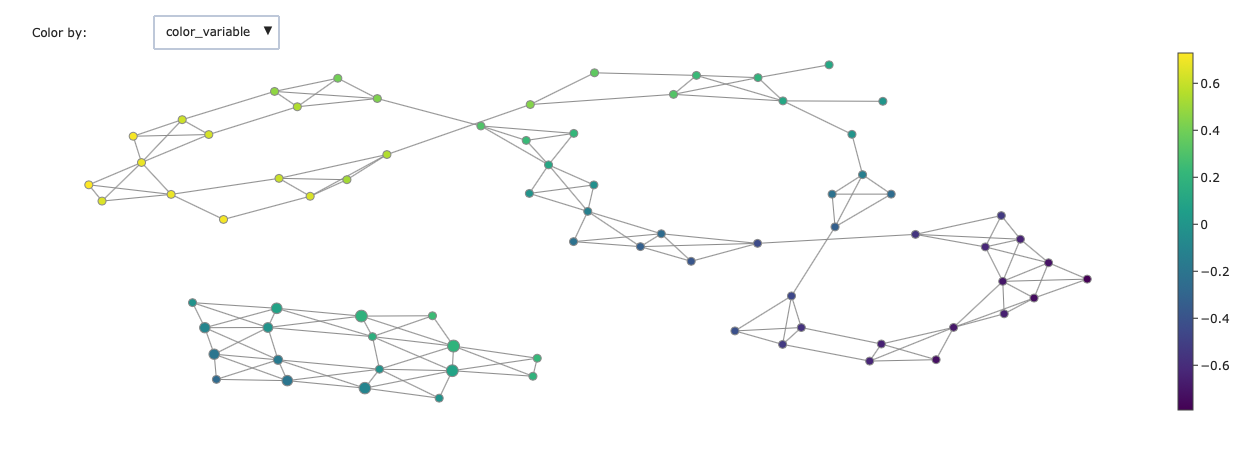

In [58]:
fig = plot_static_mapper_graph(
    pipe, data, layout="fruchterman_reingold", color_by_columns_dropdown=True
)
fig.show(config={'scrollZoom': True})

### Change the layout dimension

It is also possible to visualise the Mapper graph in 3-dimensions by configuring the `layout_dim` argument:

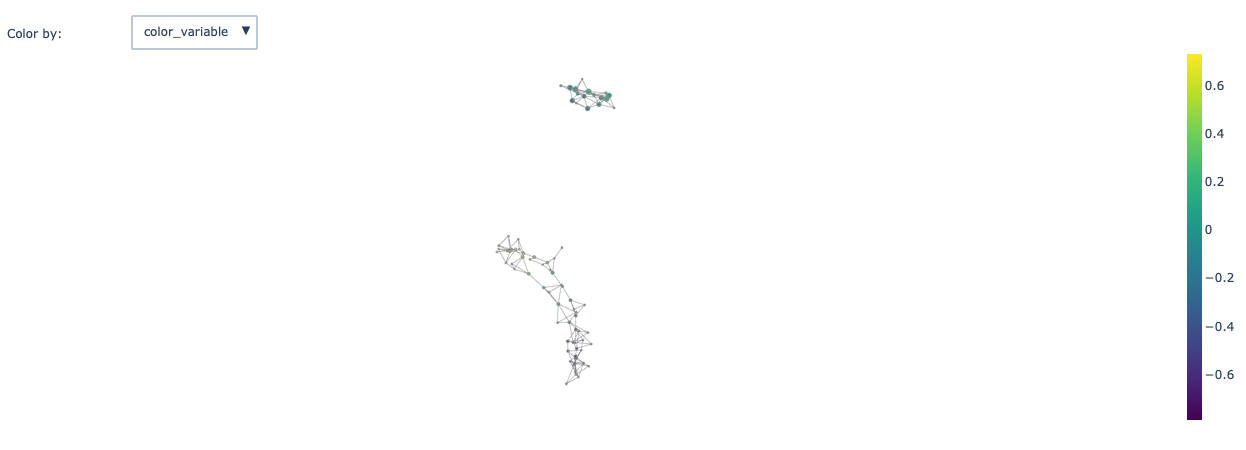

In [60]:
fig = plot_static_mapper_graph(pipe, data, layout_dim=3, color_by_columns_dropdown=True)
fig.show(config={'scrollZoom': True})

### Change the node size scale

In general, node sizes are proportional to the number of dataset elements contained in the nodes. Sometimes, however, the default scale leads to graphs which are difficult to decipher, due to e.g. excessively small nodes. The `node_scale` parameter can be used to configure this scale. 

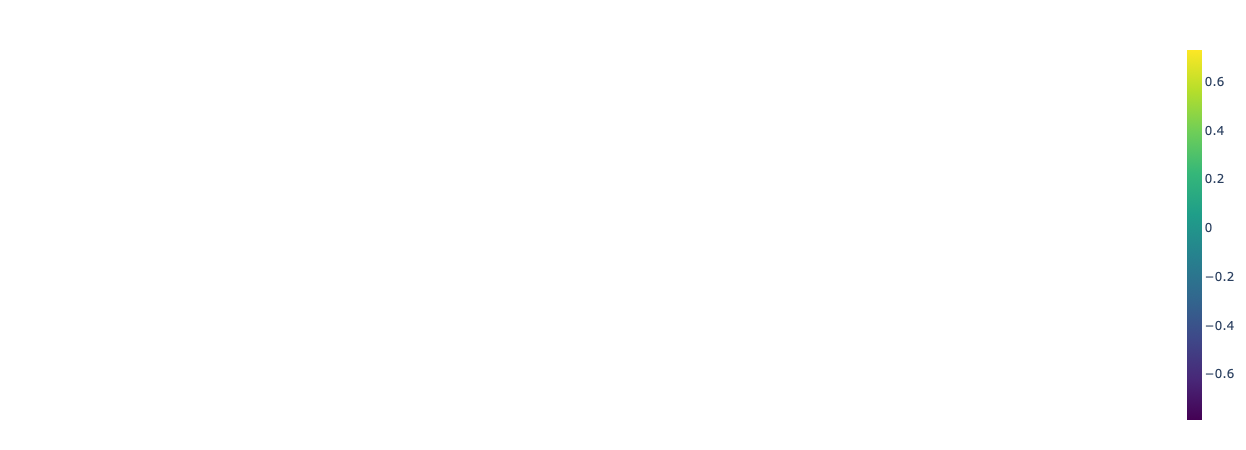

In [61]:
node_scale = 30
fig = plot_static_mapper_graph(pipe, data, layout_dim=3, node_scale=node_scale)
fig.show(config={'scrollZoom': True})

## Run the Mapper pipeline

Behind the scenes of `plot_static_mapper_graph()` is a `MapperPipeline` object `pipe` that can be used like a typical `scikit-learn` estimator. For example, to extract the underlying graph data structure we can do the following:

In [62]:
graph = pipe.fit_transform(data)

The resulting graph is a [`python-igraph`](https://igraph.org/python/) object that contains metadata that is stored in the form of dictionaries. We can access this data as follows:

In [63]:
graph["node_metadata"].keys()

dict_keys(['node_id', 'pullback_set_label', 'partial_cluster_label', 'node_elements'])

Here `node_id` is a globally unique node identifier used to construct the graph, while `pullback_set_label` and `partial_cluster_label` refer to the interval and cluster sets described above. The `node_elements` refers to the indices of our original data that belong to each node. For example, to find which points belong to the first node of the graph we can access the desired data as follows:

In [64]:
node_id, node_elements = (
    graph["node_metadata"]["node_id"],
    graph["node_metadata"]["node_elements"],
)

In [65]:
print(
    "Node ID: {}, \nNode elements: {}, \nData points: {}".format(
        node_id[0], node_elements[0], data[node_elements[0]]
    )
)

Node ID: 0, 
Node elements: [ 462  627  803 1722 1969 2145 2573 2603 2769 2957 3666 4398], 
Data points: [[-0.89681717 -0.55974007]
 [-0.9155821  -0.46166875]
 [-0.95633144 -0.48215542]
 [-0.93009448 -0.48104422]
 [-0.95655947 -0.55155508]
 [-0.9546744  -0.49966423]
 [-0.92626864 -0.60832188]
 [-0.93586738 -0.47145077]
 [-0.91803077 -0.49548077]
 [-0.89123057 -0.59910578]
 [-0.9212387  -0.54977963]
 [-0.92613737 -0.52307787]]


## Creating custom filter functions

In some cases, the list of filter functions provided in `gtda.mapper.filter.py` or `scikit-learn` may not be sufficient for the task at hand. In such cases, one can pass any callable to the pipeline that acts **row-wise** on the input data. For example, we can project by taking the sum of the $(x,y)$ coordinates as follows:

In [66]:
filter_func = np.sum

pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=True,
    n_jobs=n_jobs,
)

[Pipeline] ............ (step 1 of 3) Processing scaler, total=   0.0s
[Pipeline] ....... (step 2 of 3) Processing filter_func, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing cover, total=   0.0s
[Pipeline] .... (step 1 of 3) Processing pullback_cover, total=   0.0s
[Pipeline] ........ (step 2 of 3) Processing clustering, total=   0.0s
[Pipeline] ............. (step 3 of 3) Processing nerve, total=   0.0s


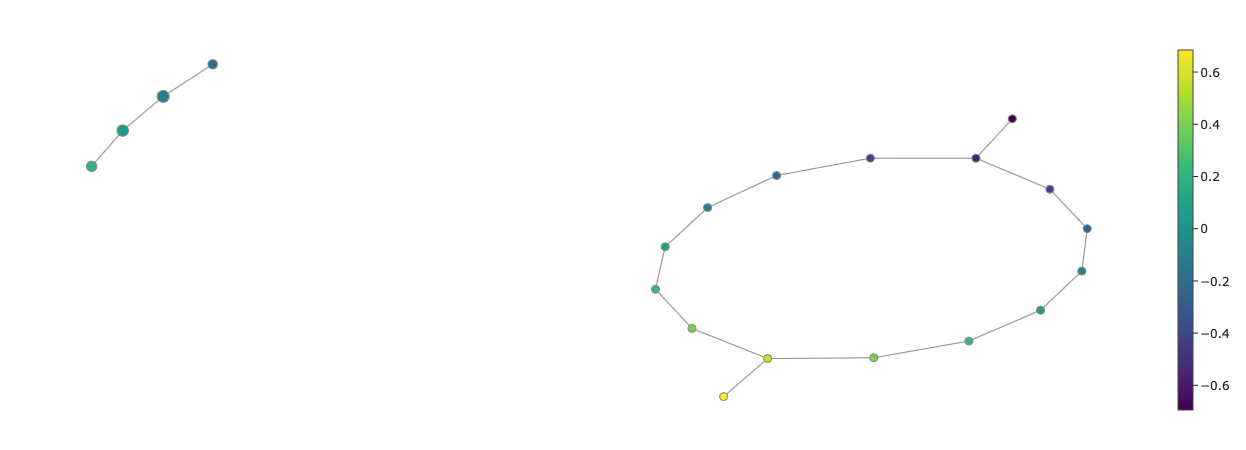

In [67]:
fig = plot_static_mapper_graph(pipe, data)
fig.show(config={'scrollZoom': True})

## Visualise the 2D Mapper graph interactively (Live Jupyter session needed)

In general, building useful Mapper graphs requires some iteration through the various parameters in the cover and clustering algorithm. To simplify that process, `giotto-tda` provides an interactive figure that can be configured in real time.

If invalid parameters are selected, the _Show logs_ checkbox can be used to see what went wrong.

To see the interactive output, please **download** the notebook from [github](https://github.com/giotto-ai/giotto-tda/blob/master/examples/mapper_quickstart.ipynb) and execute it locally.

In [68]:
pipe = make_mapper_pipeline()

# Generate interactive widget
plot_interactive_mapper_graph(pipe, data, color_by_columns_dropdown=True)